In [ ]:
# kaggle : https://www.kaggle.com/competitions/global-wheat-detection/data
# -> 대회 : 벼 이삭에 대한 객체 탐지( 분류 X )
#            탐지를 할 대상( 벼 이삭들의 종류/ 품종 )
# -> 다양한 품종에 대한 벼 이삭들의 정보들을 학습

In [ ]:
# 기존 학습 모델을 바탕으로 Box문제들을 처리할 때 문제점은 기준 좌표
# - yolo : x,y,w,h ==> x,y가 박스의 중심좌표
# - coco : x,y,w,h ==> x,y가 박스의 좌측 상단!!!!(일반적으로 두루 사용하는 기준)
# ==> 값은 순서나 이런 변수나 동일해도 다른 의미를 가질 수 있음!!!!

# 결론 : 캐글

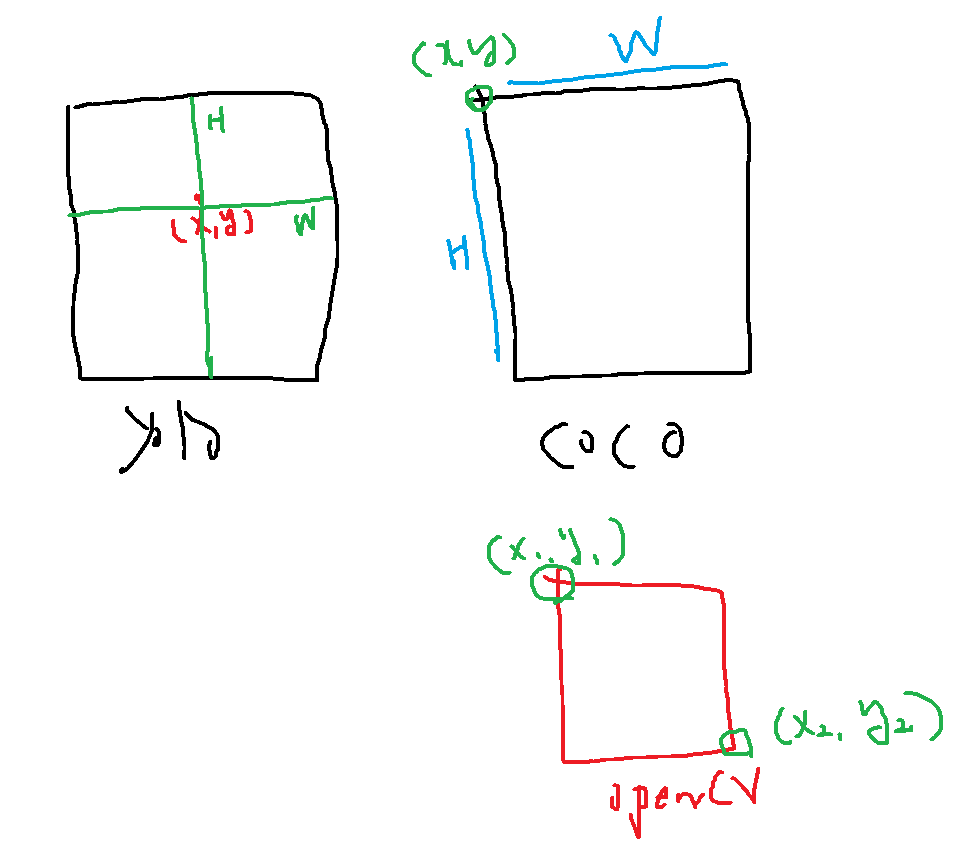

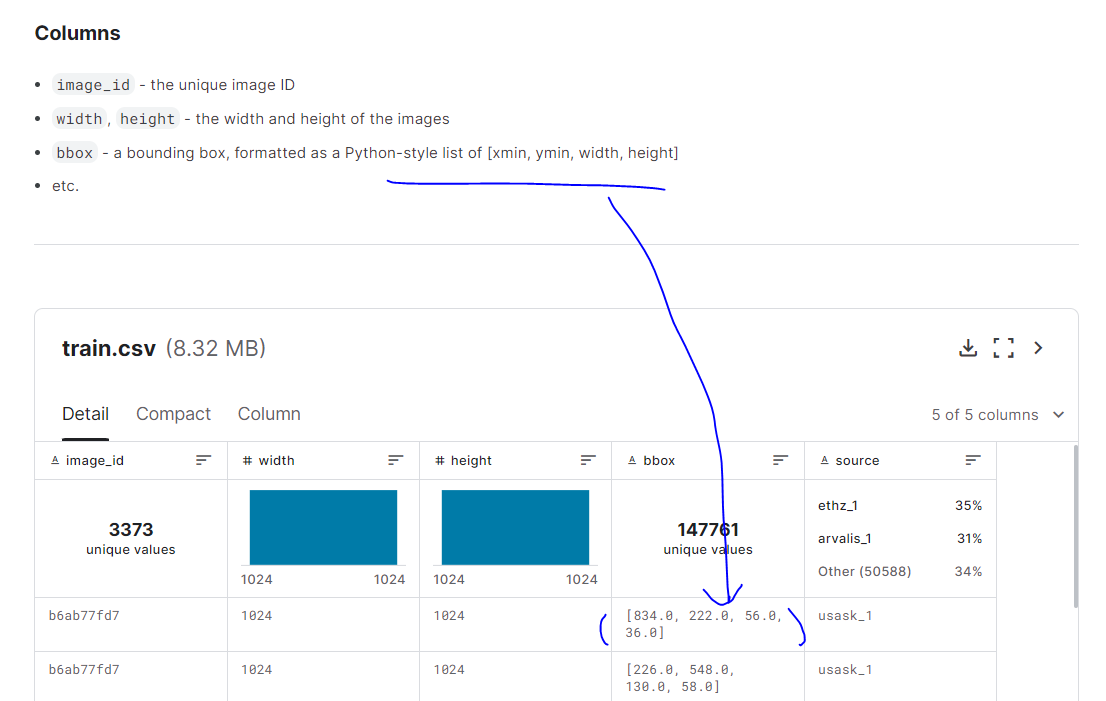

In [ ]:
# kaggle에 있는 데이터 셋을 구굴 드라이브에 압축해서 올림!!!
!gdown 1iXn1p_bW4JO9qL3iSkXNFh7ngqs-gkhA

Downloading...
From (original): https://drive.google.com/uc?id=1iXn1p_bW4JO9qL3iSkXNFh7ngqs-gkhA
From (redirected): https://drive.google.com/uc?id=1iXn1p_bW4JO9qL3iSkXNFh7ngqs-gkhA&confirm=t&uuid=94cc9c02-2fde-41d4-8a29-7ef17bbfc68c
To: /content/global-wheat-detection.zip
100% 637M/637M [00:09<00:00, 64.4MB/s]


In [ ]:
# kaggle 데이터 압축 파일 풀기
!unzip -qq "/content/global-wheat-detection.zip" -d "/content/data/"

In [ ]:
# 기본적인 데이터 처리
# ==> 정답 박스들은 csv에 존재 : pandas
# ==> train만 있고,, val이 없음..
# ==> datagenerator // scikit-learn을 사용하는 train_test_split
import numpy as np
import pandas as pd
import os
from tqdm.auto import tqdm # 반복문 속에서 진행 상태 볼 때 사용패키지
import shutil as sh
from sklearn.model_selection import StratifiedKFold

In [ ]:
# train 정보들을 확인..
df = pd.read_csv("/content/data/train.csv")
df.head()

,image_id,width,height,bbox,source
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1


In [ ]:
df.loc[0,"bbox"]

'[834.0, 222.0, 56.0, 36.0]'

In [ ]:
# ---> 박스 좌표에 대한 문자열을 리스트로 변환을 하는게 유용함
# + 이미지 id는 잠시 제외하고 경계 정보만 추출 하겠음.
bboxs = np.stack(
    df.loc[:, "bbox"].apply(lambda x: np.fromstring(x[1:-1], sep=","))
)
bboxs

array([[834., 222.,  56.,  36.],
       [226., 548., 130.,  58.],
       [377., 504.,  74., 160.],
       ...,
       [134., 228., 141.,  71.],
       [430.,  13., 184.,  79.],
       [875., 740.,  94.,  61.]])

In [ ]:
# df에서 yolo 중심의 좌표값으로 변환을 하는게 목적!!
# ==> 주어진 데이터는 coco방식으로 좌측 상단이 기준 좌표!!!!
# ==> 다 숫자로 일단 주어진 coco방식의 데이터를 수치화!!!
for i , column in enumerate( ["x","y","w","h"]):
    df[column] = bboxs[:, i]
df.head()

,image_id,width,height,bbox,source,x,y,w,h
0,b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,"[26.0, 144.0, 124.0, 117.0]",usask_1,26.0,144.0,124.0,117.0


In [ ]:
df.drop( columns = ["bbox"], inplace=True)
df.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [ ]:
# yolo가 학습을 위해서 필요한 중심 좌표로 변환
# => W/H는 그대로 유지가 되어서 따로 파생 안해도 됨
df["x_center"] = df["x"] + df["w"]/2
df["y_center"] = df["y"] + df["h"]/2
# + yolo3을 재학습을 시켜야 함!!!!
#      coco.names---> 학습할 대상의 이름!!!!
#      벼 : 새로운 클래스/카테고리의 정보를 부여!!!!
df["classes"] = 0 # yaml 로 학습을 할 대상에 대한 세팅에서 문제가 됨
# + 내가 더 종별로 하겠다면, 종별로 클래스들을 하시면 됨
df.head()

,image_id,width,height,source,x,y,w,h,fold,x_center,y_center,classes
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0,1.0,862.0,240.0,0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0,4.0,291.0,577.0,0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0,3.0,414.0,584.0,0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0,2.0,888.5,148.5,0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0,2.0,88.0,202.5,0


In [ ]:
# train/val 분리
# yolo v3로 위의 벼 데이터를 학습시키기 위한 환경설정 파일 생성
# yolo v3 train.py를 활용해서 실행
# test에서 yolo3 기반으로 벼 이삭 박스 찾는 모델을 적용
# kaggle에 업로드용 파일 스타일에 맞춰서 생성해서 업로드!

In [ ]:
# 기존 좋은 모델을 기본으로 해서
# 내 목적에 맞는 데이터셋에 대한 재학습
# ==> Fine Tunning을 하려고 함


In [ ]:
# yolo 이미지 : 폴더 구조를 세팅을 해야 함!!!!!!
# 학습용 폴더 ( 이미지 분류 : train 폴더 아래에 하위 폴더로 지정하면 처리)
#    ===> dog breed 분류 세팅과 동일함!!!!
#     - train
#     - valid
#     - test

In [ ]:
# 시간상 일부만 학습하도록 하겠음
# -> 이 부분은 단순 데이터 조절용으로 사용한 것이므로 전체학습이 아님!

In [ ]:
df.shape

(147793, 8)

In [ ]:
fold_id = np.zeros( (df.shape[0],  1) )
fold_id.shape

(147793, 1)

In [ ]:
skf = StratifiedKFold( n_splits = 5,
                      random_state=1234,
                       shuffle=True)
# ---> 이 부분을 바탕으로 데이터 셋을 분리 작업을 하려고 함!!

In [ ]:
df["source"].value_counts()

,count
source,
ethz_1,51489
arvalis_1,45716
rres_1,20236
arvalis_3,16665
usask_1,5807
arvalis_2,4179
inrae_1,3701


In [ ]:
# ==> train 데이터 셋에 있어서 source에 대해서 비율을 유지하면서 학습 셋을 분리
for (num, (train_index, test_index) ) in enumerate( skf.split(df, df["source"])):
    fold_id[ test_index] = int(num)
df["fold"] = fold_id.copy()
df.head()

,image_id,width,height,source,x,y,w,h,fold
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0,1.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0,4.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0,3.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0,2.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0,2.0


In [ ]:
#gridsearch( model, cv=stf ) # 셋 구성에 대한 내용

In [ ]:
df["fold"].value_counts()

,count
fold,
1.0,29559
2.0,29559
0.0,29559
4.0,29558
3.0,29558


In [ ]:
df.head()

,image_id,width,height,source,x,y,w,h,fold
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0,1.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0,4.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0,3.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0,2.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0,2.0


In [ ]:
# ===> 필요한 정보들만 가지고 재 구성을 하면 됨
# ===> 필요한 정보들만 가지고 구성을 하자
# 참고) source는 데이터셋 분리에만 사용을 했고,그래서 더 필요 없어서 생략
# 참고) classes는 여러가지를 해야한다면,다른 라벨 인코딩 값으로 지정!!!!
#       지금은 0번으로 1개 대상만 했음!!
df = df.loc[:, ["image_id", "x","y","w","h", "x_center", "y_center", "classes","fold"]]
df.head()

,image_id,x,y,w,h,x_center,y_center,classes,fold
0,b6ab77fd7,834.0,222.0,56.0,36.0,862.0,240.0,0,1.0
1,b6ab77fd7,226.0,548.0,130.0,58.0,291.0,577.0,0,4.0
2,b6ab77fd7,377.0,504.0,74.0,160.0,414.0,584.0,0,3.0
3,b6ab77fd7,834.0,95.0,109.0,107.0,888.5,148.5,0,2.0
4,b6ab77fd7,26.0,144.0,124.0,117.0,88.0,202.5,0,2.0


In [ ]:
# Yolo로 학습을 하기 위해서는 폴더 구조로 세팅을 해야 함
source ="train"

# 시간 관계상 줄여서 하기 위해서 위의 셋 중에서 0번만 선택해서 하겠습니다
fold = 0
val_index = list( df[df["fold"]==fold]["image_id"])
print(val_index)

['b6ab77fd7', 'b6ab77fd7', 'b6ab77fd7', 'b6ab77fd7', 'b6ab77fd7', 'b6ab77fd7', 'b6ab77fd7', 'b6ab77fd7', 'b53afdf5c', 'b53afdf5c', 'b53afdf5c', 'b53afdf5c', 'b53afdf5c', 'b53afdf5c', 'b53afdf5c', 'b53afdf5c', 'b53afdf5c', 'b53afdf5c', 'b53afdf5c', 'b53afdf5c', 'b53afdf5c', 'b53afdf5c', '7b72ea0fb', '7b72ea0fb', '7b72ea0fb', '7b72ea0fb', '7b72ea0fb', '91c9d9c38', '91c9d9c38', '91c9d9c38', '91c9d9c38', '91c9d9c38', '41c0123cc', '41c0123cc', '41c0123cc', '41c0123cc', '41c0123cc', 'c682d8c66', 'c682d8c66', 'c682d8c66', 'c682d8c66', 'c682d8c66', 'e46378032', 'e46378032', 'e46378032', 'e46378032', 'e46378032', 'e46378032', '71fd03d51', '71fd03d51', '71fd03d51', '71fd03d51', '71fd03d51', '71fd03d51', '83a5d8ac8', '83a5d8ac8', '83a5d8ac8', '83a5d8ac8', '83a5d8ac8', '02b6f199c', '02b6f199c', '02b6f199c', '02b6f199c', '02b6f199c', '02b6f199c', '02b6f199c', '1bda74f14', '1bda74f14', '1bda74f14', '3e1e66c76', '3e1e66c76', '3e1e66c76', '3e1e66c76', '3e1e66c76', '3e1e66c76', '3e1e66c76', '4a3f67d2e'

In [ ]:
len(val_index)

29559

In [ ]:
# 이미지 파일 이동
# 셋은 1장의 이미지에 여러개의 벼 이삭의 박스가 존재!!!
#      이미지 id를 기준으로 폴더 구조용 파일 처리..
for name, name_data in tqdm(df.groupby("image_id")):
    # name : 이미지
    # name_data : 위의 정보들..
    if name in val_index:
        save_path = "valid/"
    else:
        save_path ="train/"

    # 폴더 구조를 생성
    if not os.path.exists("convertor/fold{}/labels/".format(fold)+save_path):
        os.makedirs("convertor/fold{}/labels/".format(fold)+save_path)
    # 관련된 파일을 yolo 학습을 위해서 생성...
    with open("convertor/fold{}/labels/".format(fold)+save_path+name+".txt","w+" ) as f:
        # 이미지 별로 관련 정보 txt 파일 생성..
        # ==> yolo3 기준으로 좌표들을 상대좌표.......상대좌표 밀어넣어줘야 함..
        row = name_data[ [ "classes", "x_center", "y_center","w","h"]].astype(float).values
        row = row / 1024 # yolo 의 입력 좌표들을 상대좌표화...1024 이 데이터는 일괄대게 1024
        # ==> 수집한 이미지의 크기가 다르면,,,각기 크기 별로 상대 좌표화 해야함...
        # 참고) 이미지 별로 크기가 다양할 때는 신경써서 해야 함...
        row = row.astype( str) # text 파일에 작성을 위해서 명확하게 문자열화..숫자를.
        for j in range( len(row)):
            # 1개 이미지 파일에 있는 개별 박스에 대한 정보들을 쭉....
            text = " ".join(row[j])
            f.write(text)
            f.write("\n")
    # 실제 학습을 위한 이미지들을 폴더구조로 복사를 해둬야 함!!!
    if not os.path.exists("convertor/fold{}/images/{}".format(fold,save_path)):
        os.makedirs("convertor/fold{}/images/{}".format(fold,save_path ))
    sh.copy( "/content/data/{}/{}.jpg".format(source,name ) ,
             "convertor/fold{}/images/{}/{}.jpg".format(fold, save_path,name ))
    # ---> convertor/fold0/images/train/~~~/jpg
    #      convertor/fold0/images/valid/~~~/jpg

  0%|          | 0/3373 [00:00<?, ?it/s]

In [ ]:
# 그 다음에 yolo 에 대한 코드들을 가지고 와야 함!!!
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17080, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 17080 (delta 21), reused 7 (delta 7), pack-reused 17050 (from 3)
Receiving objects: 100% (17080/17080), 15.69 MiB | 19.31 MiB/s, done.
Resolving deltas: 100% (11726/11726), done.


In [ ]:
%cd yolov5

/content/yolov5


In [ ]:
!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 904.4/904.4 kB 48.0 MB/s eta 0:00:00


In [ ]:
# !git clone https://github.com/ultralytics/yolov5  && cd yolov5 && pip install -r requirements.txt

In [ ]:
# 기존의 coco셋이 아닌 원하는 데이터로 학습 진행
# 학습을 위한 yaml 파일 직접 작성(json)
# 참고) 다른 사람들도 환경설정, 모델 설정들을 yaml 파일로 작성하는 경우들이 있음.

# 기록할 정보
# 1) train 폴더의 위치 : train
# 2) valid 폴더의 위치 : val
# 3) txt 파일에 대한 적성한 종류 수 : nc (단, 지금은 벼이삭)
# 4) names 에 구체적인 대상의 이름 순서대로 : names
# ==> yaml파일로 작성

In [ ]:
# 작성방법1) 직접 txt파일 열어서(메모장) 작성,
# 작성방법2) 코드로 작성 ***
# ==> 주의사항!!!!!
# 항목 다음에 무조건 한 칸 공백!! **** 에러 발생 요인 ****
# ==> 양식/공백/: 위치등은 정확하게 맞춰서 해야 함!!! : 다음에 무조건 한 칸 공백!!!
yaml_text = """train: /content/convertor/fold0/images/train/
val: /content/convertor/fold0/images/valid/

nc: 1
names: ['wheat']
"""

In [ ]:
with open("wheat.yaml", "w") as f:
    f.write(yaml_text)

In [ ]:
# 실제 작성한 파일을 확인을 하면
# 1) colab 파일을 직접 클릭
# 2) 명령어로 확인
!cat wheat.yaml

train: /content/convertor/fold0/images/train/
val: /content/convertor/fold0/images/valid/

nc: 1
names: ['wheat']


In [ ]:
#####=====> 준비 세팅 끝!

In [ ]:
# train.py를 할 때 필요한 세팅들 몇 가지만
# 1. train.py를 사용을 하려고 함.
# ==> 그냥 yolo5 기존 학습 pre-trained weight 값으로 시작
# 2. --img 512 : 원본의 이미지를 512로 줄여서 학습을 함.(속도때문에)
# 3. --batch /-- epoch
# 4. --data : 내가 학습시키고자하는 대상에 대한 정보 yaml파일
#           wheat.yaml 지정을 하면 됨
# 5. --names

In [ ]:
!python ./yolov5/train.py --img 512 --batch 2 --epochs 3 --workers 2 --data wheat.yaml --weights yolov5s.pt --name yolov5s_fold0

wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2024-12-31 19:33:36.114042: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-31 19:33:36.156932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-31 19:33:36.169090: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visua

In [ ]:
# 설명의 요지
# yolo 범용적인 모델을 활용해서 나의 데이터에 맞게 학습을 하기 위해서 여러 세팅이 필요
# 1) 좌표에 대한 정보 처리
# 2) 폴더 구조 + 각 대상별로 학습 정보 txt파일.(구체적)
# 3) 학습을 할 yaml 을 작성(큰 정보)
# ===> 이 중에서 하나라도 틀어지면 안 돌아 감;;;
# ===> yaml 생성 중에서 공백처리부분에 유의!!!!! (에러 파악이 어려움..)

In [ ]:
# 학습이 원하는대로 되었다면 ---> 적용!!!!
# 학습 : train.py
# 적용 : detect.py

# conf : 유의수준
# img  : 이미지 처리할 사이즈 512
# source : 테스트할 이미지들이 있는 경로
# weight :

In [ ]:
!python ./yolov5/detect.py --weights ./yolov5/runs/train/yolov5s_fold0/weights/best.pt --conf 0.1 --img 512 --source ./data/test --save-txt --save-conf

In [ ]:
# 실행을 하면
# 주로 yolo 폴더 내의 run하위 폴더 내에 생성이 됨...
# ==>yolov5/runs/detect/exp2/labels안에 txt 파일로 이미지별로 결과 box
# ==> yolov5/runs/detect/exp2/ 검출된 박스들의 이미지들이...

In [ ]:
# /content/yolov5/runs/detect/exp2/labels/2fd875eaa.txt
# 0 0.881836 0.578613 0.236328 0.243164 0.116971
# ==> 6개에 대한 정보를 던져 줌!! yolo
# 처음 : 그 이미지에서 검출한 대상
# 2번째 : 처리된 비율에 대한
# 3~6번째 : x,y,w,h순서대로 정보다 들어 있음.
# =========> 비율값을 ( 상대적인 값 )
# =========> 픽셀로 환을 해야 하는 또 귀찮은 작업이 있음!!!

In [ ]:
### yolo가 학습한 결과(상대좌표) 중심 x,y을
# === 절대좌표(1024)& 기준좌표(x,y)--> 좌측상단 좌표(x,y)
def convt_yo_kaggle( yolo_pos):
    x = int( 1024 * (yolo_pos[1]-yolo_pos[3]/2 ) ) # 비율 & 계산(좌측 상단으로 이동)
    y = int( 1024 * (yolo_pos[2] - yolo_pos[4]/2) ) # 비율 & 계산(좌측 상단으로 이동)
    w = int( 1024 * yolo_pos[3]) # 비율만
    h = int( 1024 * yolo_pos[4]) # 비율만
    return ( str(x)+","+str(y)+","+str(w)+","+str(h))
# ==> 이미지 픽셀 중심으로 값을 줘야 하기에 int로 형을 변환을 함
# ==> 1~2 픽셀은 밀리거나 오차가 발생함!!!!!

In [ ]:
# ===> 내가 처리한 모델들이/ 학습 결과들이
#      어떤 정보/기준들로 값들을 주는지 꼭 체크
# ===> 종종 변환을 사용해야 하는 경우가 있음

In [ ]:
import os
import pandas as pd

In [ ]:
# Kaggle에 맞도록 다시 제출용
# ==> sample_submission.csv
with open("my_sub.csv", "w") as mf:
    # test한 결과들에 대한 txt 파일에 있는 좌표
    result_folder = "./yolov5/runs/detect/exp2/labels/"
    for f in os.listdir(result_folder):
        file_name = result_folder + f
        data = pd.read_csv(file_name, sep=" ", header=None)
        temp_box = ",".join( list(data.apply(lambda x: convt_yo_kaggle(x), axis=1 ) ) )
        mf.write(f+temp_box+"\n")
mf.close()

In [ ]:
##### kaggle에서 기존 모델을 가지고 kaggle의 문제를 푸는 방식 중 하나 ####
# level 0 : 가장 기본적인 구조
# ==> yolo 형식& 작성할 파일
# ==> 좌표값에 대한 처리
# (처음 하신 분들은 머리에서 혼동이 돔!!!!)
# --> 코드화 작업도 해야함
# ++++
# kaggle에 제출용으로 다시 정리해서 업로드하는 것도 필요